In [5]:
from kan import *
from kan import KAN
import matplotlib.pyplot as plt
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
dtype = torch.get_default_dtype()

cpu


Loading IRIS dataset...
Train size: 120, Test size: 30
------------------------------
Training KAN on IRIS...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.20e-04 | test_loss: 2.96e-01 | reg: 6.17e+01 | : 100%|█| 200/200 [00:43<00:00,  4.62


saving model version 0.1
Final KAN Test Accuracy: 0.9667
------------------------------
Training MLP on IRIS...


| train_loss: 3.48e-01 | test_loss: 3.52e-01 | reg: 3.43e+01 | : 100%|█| 20/20 [00:00<00:00, 25.51it


Final MLP Test Accuracy: 1.0000
------------------------------


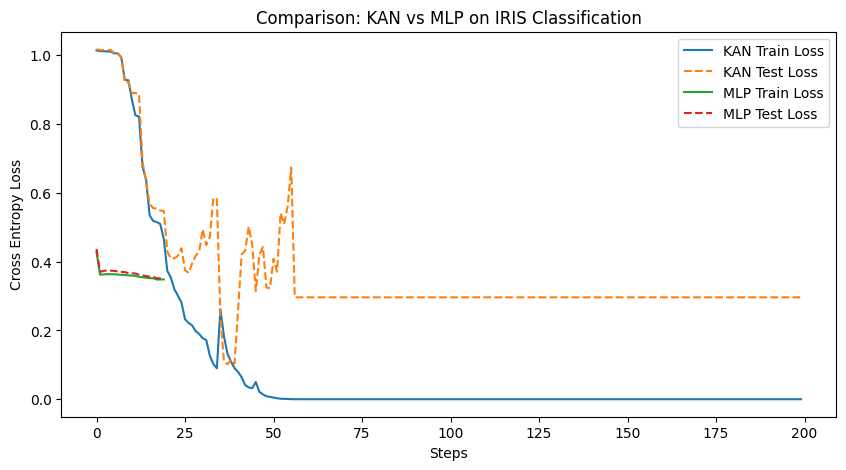

Automatic Symbolic Regression for KAN (Iris):
fixing (0,0,0) with x, r2=0.9312658905982971, c=1
fixing (0,0,1) with x, r2=0.22438229620456696, c=1
fixing (0,0,2) with x, r2=0.9999567866325378, c=1
fixing (0,1,0) with x, r2=0.687166690826416, c=1
fixing (0,1,1) with x, r2=0.7467666268348694, c=1
fixing (0,1,2) with x, r2=0.9993466138839722, c=1
fixing (0,2,0) with x, r2=0.9959155917167664, c=1
fixing (0,2,1) with x, r2=0.6417754888534546, c=1
fixing (0,2,2) with x, r2=0.9995033740997314, c=1
fixing (0,3,0) with x, r2=0.9445584416389465, c=1
fixing (0,3,1) with x, r2=0.9884165525436401, c=1
fixing (0,3,2) with x, r2=0.9754382371902466, c=1
fixing (1,0,0) with sin, r2=0.9932636022567749, c=2
fixing (1,0,1) with sin, r2=0.9932945370674133, c=2
fixing (1,0,2) with x, r2=0.8855441808700562, c=1
fixing (1,1,0) with x, r2=0.9670243263244629, c=1
fixing (1,1,1) with x, r2=0.9564993977546692, c=1
fixing (1,1,2) with x, r2=0.9544023275375366, c=1
fixing (1,2,0) with x, r2=0.08117429912090302, c=1

In [6]:
# --- 1. Load and Prepare IRIS Dataset ---
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

print("Loading IRIS dataset...")
iris = load_iris()
X = iris.data
y = iris.target

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create dataset dictionary expected by KAN/MLP
dataset_iris = {}
dtype = torch.get_default_dtype()

dataset_iris['train_input'] = torch.from_numpy(X_train).type(dtype).to(device)
dataset_iris['test_input'] = torch.from_numpy(X_test).type(dtype).to(device)
dataset_iris['train_label'] = torch.from_numpy(y_train).type(torch.long).to(device)  # Labels must be Long for CrossEntropy
dataset_iris['test_label'] = torch.from_numpy(y_test).type(torch.long).to(device)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
print("-" * 30)

# --- 2. Train KAN Classifier ---
print("Training KAN on IRIS...")
# Architecture: 4 inputs -> 5 hidden neurons -> 3 output classes
kan_model = KAN(width=[4, 3, 3, 3], grid=200, k=3, seed=42, device=device)

# Define accuracy metrics
def train_acc_kan():
    return torch.mean((torch.argmax(kan_model(dataset_iris['train_input']), dim=1) == dataset_iris['train_label']).type(dtype))

def test_acc_kan():
    return torch.mean((torch.argmax(kan_model(dataset_iris['test_input']), dim=1) == dataset_iris['test_label']).type(dtype))

# Fit KAN
results_kan = kan_model.fit(
    dataset_iris,
    opt="LBFGS",
    steps=200,
    metrics=(train_acc_kan, test_acc_kan),
    loss_fn=torch.nn.CrossEntropyLoss()
)
print(f"Final KAN Test Accuracy: {results_kan['test_acc_kan'][-1]:.4f}")
print("-" * 30)

# --- 3. Train MLP Classifier ---
print("Training MLP on IRIS...")
from kan.MLP import MLP

# Architecture: 4 inputs -> 64 hidden neurons -> 3 output classes
# MLP usually requires more hidden neurons to match KAN's expressivity
mlp_model = MLP(width=[4, 64, 3], seed=42, device=device)

# Fit MLP (Note: MLP.fit might not support 'metrics' tuple in older versions,
# so we calculate accuracy manually after training, but we pass loss_fn for classification)
results_mlp = mlp_model.fit(
    dataset_iris,
    opt="LBFGS",
    steps=20,
    lamb=0.01,
    loss_fn=torch.nn.CrossEntropyLoss()
)

# Calculate MLP Accuracy manually
mlp_pred_test = torch.argmax(mlp_model(dataset_iris['test_input']), dim=1)
mlp_acc = torch.mean((mlp_pred_test == dataset_iris['test_label']).type(dtype))
print(f"Final MLP Test Accuracy: {mlp_acc:.4f}")
print("-" * 30)

# --- 4. Comparison Plot ---
plt.figure(figsize=(10, 5))
plt.plot(results_kan['train_loss'], label='KAN Train Loss')
plt.plot(results_kan['test_loss'], label='KAN Test Loss', linestyle='--')
# MLP fit returns a list of losses directly in some versions, or a dict in others.
# Assuming standard KAN lib return structure for MLP:
if isinstance(results_mlp, dict) and 'train_loss' in results_mlp:
    plt.plot(results_mlp['train_loss'], label='MLP Train Loss')
    plt.plot(results_mlp['test_loss'], label='MLP Test Loss', linestyle='--')

plt.title("Comparison: KAN vs MLP on IRIS Classification")
plt.xlabel("Steps")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()

# --- 5. Symbolic Formula from KAN (Bonus) ---
print("Automatic Symbolic Regression for KAN (Iris):")
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
kan_model.auto_symbolic(lib=lib)
formula_iris = kan_model.symbolic_formula()[0]
print(f"Class 0 Formula (approx): {formula_iris[0]}")



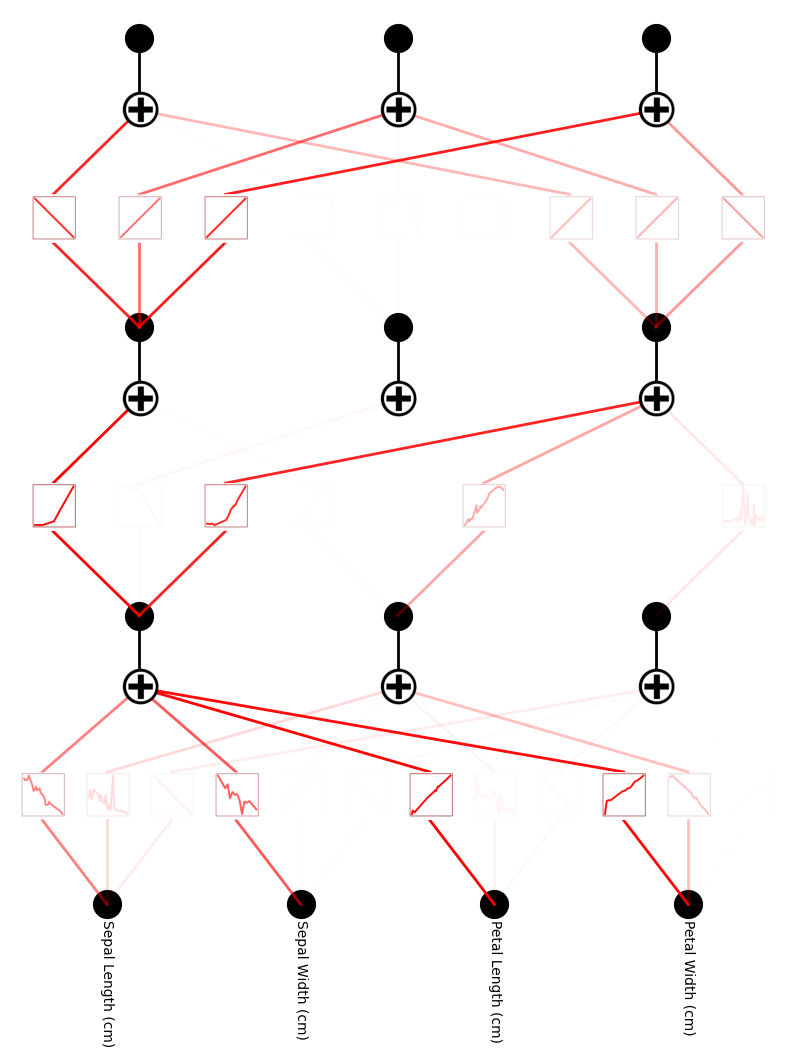

In [7]:
kan_model.plot(scale=1.0, beta=3)
n = 4
names = ["Sepal Length (cm)", "Sepal Width (cm)", "Petal Length (cm)", "Petal Width (cm)"]
for i in range(n):
    plt.gcf().get_axes()[0].text(1/(2*n)+i/n-0.005,-0.02,names[i], rotation=270, rotation_mode="anchor")

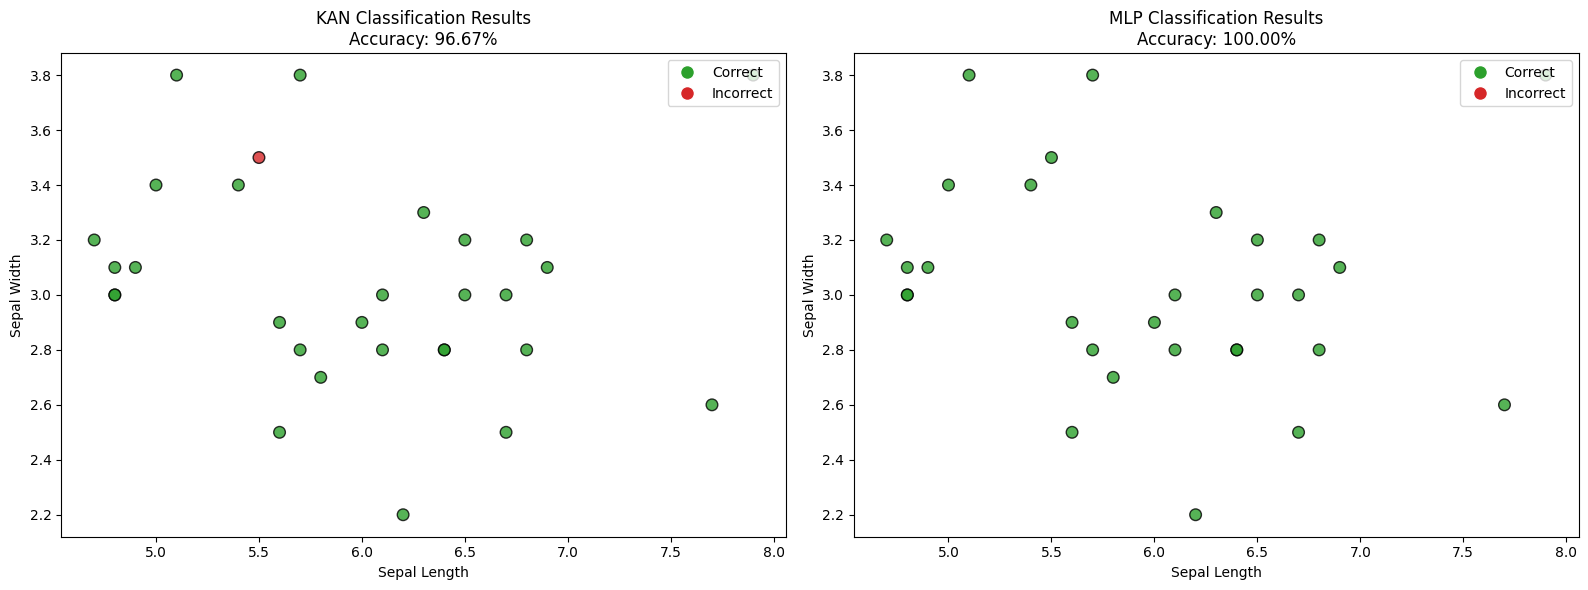

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_classification_results(kan_model, mlp_model, dataset):
    # 1. Get Data and Move to CPU
    X_test = dataset['test_input'].detach().cpu().numpy()
    y_test = dataset['test_label'].detach().cpu().numpy()

    # 2. Get Predictions
    # KAN
    kan_logits = kan_model(dataset['test_input'])
    kan_preds = torch.argmax(kan_logits, dim=1).detach().cpu().numpy()

    # MLP
    mlp_logits = mlp_model(dataset['test_input'])
    mlp_preds = torch.argmax(mlp_logits, dim=1).detach().cpu().numpy()

    # 3. Determine Correctness (Boolean masks)
    kan_correct = (kan_preds == y_test)
    mlp_correct = (mlp_preds == y_test)

    # 4. Setup Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Helper to map booleans to colors
    # Green (#2ca02c) for True, Red (#d62728) for False
    def get_colors(mask):
        return np.where(mask, '#2ca02c', '#d62728')

    # --- Plot KAN Results ---
    # Plotting Feature 0 (Sepal Length) vs Feature 1 (Sepal Width)
    axes[0].scatter(
        X_test[:, 0], X_test[:, 1],
        c=get_colors(kan_correct),
        s=70, alpha=0.8, edgecolors='k'
    )
    axes[0].set_title(f'KAN Classification Results\nAccuracy: {np.mean(kan_correct):.2%}')
    axes[0].set_xlabel('Sepal Length')
    axes[0].set_ylabel('Sepal Width')

    # Add legend manually for KAN
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ca02c', markersize=10, label='Correct'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#d62728', markersize=10, label='Incorrect')
    ]
    axes[0].legend(handles=legend_elements, loc='upper right')

    # --- Plot MLP Results ---
    axes[1].scatter(
        X_test[:, 0], X_test[:, 1],
        c=get_colors(mlp_correct),
        s=70, alpha=0.8, edgecolors='k'
    )
    axes[1].set_title(f'MLP Classification Results\nAccuracy: {np.mean(mlp_correct):.2%}')
    axes[1].set_xlabel('Sepal Length')
    axes[1].set_ylabel('Sepal Width')
    axes[1].legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

# --- Run the function ---
plot_classification_results(kan_model, mlp_model, dataset_iris)